In [ ]:
# setting up export env variable if using HPC infra

import os
    
if 'LAPTOP-8I2BSKHD' in os.environ.get('NAME', ''):
    print("Select the conda environment 'music-gen'")


if 'hpc.itc.rwth-aachen.de' in os.environ.get('R_HOSTNAME', ''):
    ! pip install scipy==1.10.1

    ! pip3 install -q --user torch==2.0.1
    ! pip install -q --user nvidia-cudnn-cu11==8.5.0.96

    os.environ['PATH'] = "/home/vt367012/.local/bin:" + os.environ['PATH']

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import scipy

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

# Evaluation

## Harmony



STEPS
- Load the sample input audio and corresponding generated audio
- Perform STFT
- Visualize results for input and generated separately
- Detect dominant frequencies (local maximas) and check if they are in harmony (simple ratios) or what is the ratio of these frequencies for both input and generated audio
    - dominant frequencies can be detected
        - by using the raw numbers and looking for local maxima
        - by using the generated image and finding local maxima

In [3]:
input_audio = torch.load(
    './music_samples/conditional_input_sample_80s_blues_track_with_groovy_saxophone.pt', map_location=device
).flatten()

generated_audio = torch.load(
    './music_samples/conditional_generated_sample_80s_blues_track_with_groovy_saxophone.pt',
    map_location=device
).numpy().flatten()

sampling_rate = 32000

print(input_audio.shape)
print(generated_audio.shape)

generated_audio = generated_audio[input_audio.shape[0]:]

print(generated_audio.shape)

(480213,)
(642560,)
(162347,)


In [4]:
time_input_audio = np.linspace(
    0, input_audio.shape[0] / sampling_rate, input_audio.shape[0]
)

time_generated_audio = np.linspace(
    0, generated_audio.shape[0] / sampling_rate, generated_audio.shape[0]
)

print(time_input_audio.shape)
print(time_generated_audio.shape)

(480213,)
(162347,)


Input Audio


Generated Audio


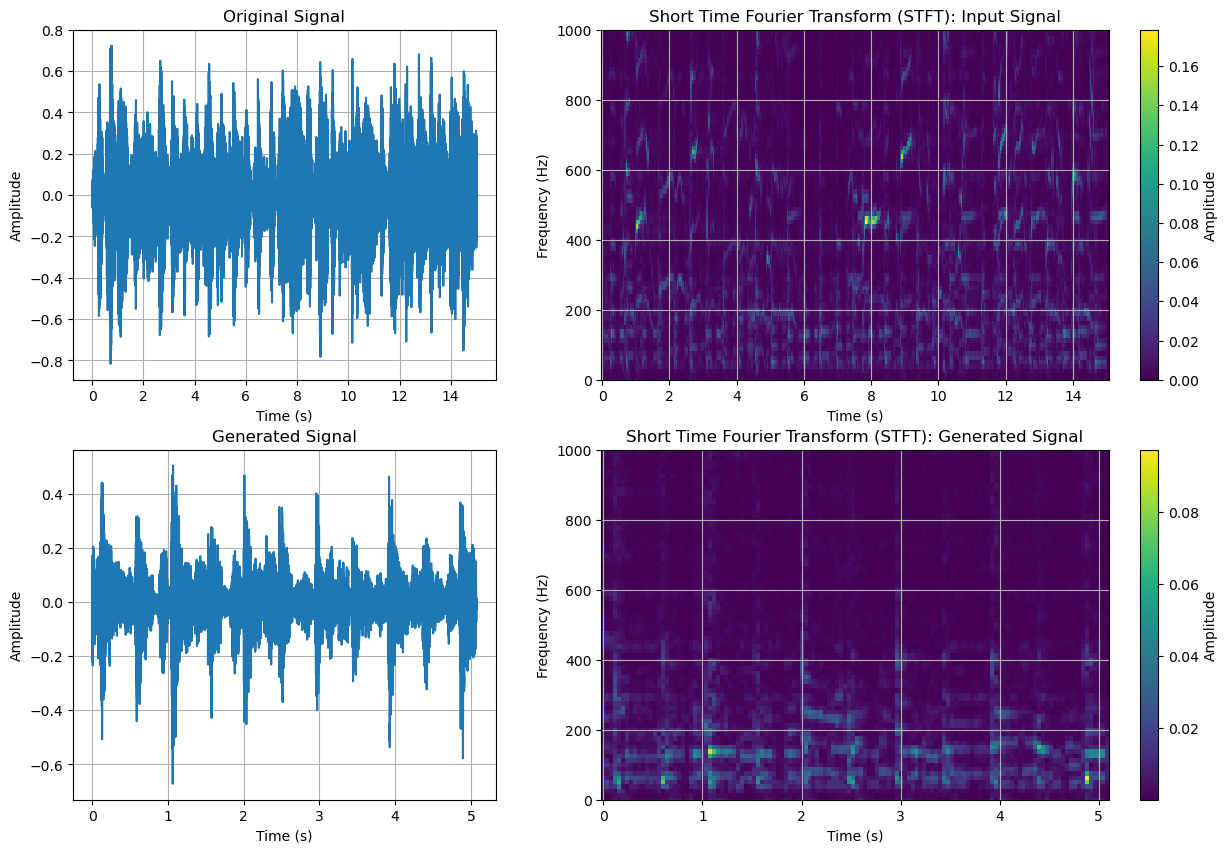

In [5]:
print("Input Audio")
display(Audio(input_audio, rate=sampling_rate))

print("Generated Audio")
display(Audio(generated_audio, rate=sampling_rate))

nperseg = 256*10
freq_input, timestamp_input, Zxx_input = scipy.signal.stft(
    input_audio, fs = sampling_rate, nperseg=nperseg)
freq_generated, timestamp_generated, Zxx_generated = scipy.signal.stft(generated_audio, fs = sampling_rate, nperseg=nperseg)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10), width_ratios=[2,3])

# Plot the original signal
ax[0,0].plot(time_input_audio, input_audio)
ax[0,0].set_xlabel('Time (s)')
ax[0,0].set_ylabel('Amplitude')
ax[0,0].set_title('Original Signal')
ax[0,0].grid()

# Plot the STFT results
plot = ax[0,1].pcolormesh(timestamp_input, freq_input, np.abs(Zxx_input), shading='auto')
plt.colorbar(plot, label='Amplitude', ax=ax[0,1])
ax[0,1].set_xlabel('Time (s)')
ax[0,1].set_ylabel('Frequency (Hz)')
ax[0,1].set_title('Short Time Fourier Transform (STFT): Input Signal')
ax[0,1].set_ylim([0,1000])
ax[0,1].grid()

# Plot the generated signal
ax[1,0].plot(time_generated_audio, generated_audio)
ax[1,0].set_xlabel('Time (s)')
ax[1,0].set_ylabel('Amplitude')
ax[1,0].set_title('Generated Signal')
ax[1,0].grid()

# Plot the STFT results
plot = ax[1,1].pcolormesh(timestamp_generated, freq_generated, np.abs(Zxx_generated), shading='auto')
plt.colorbar(plot, label='Amplitude', ax=ax[1,1])
ax[1,1].set_xlabel('Time (s)')
ax[1,1].set_ylabel('Frequency (Hz)')
ax[1,1].set_title('Short Time Fourier Transform (STFT): Generated Signal')
ax[1,1].set_ylim([0,1000])
ax[1,1].grid()

In [72]:
def fft_and_dominant_freq(audio_signal, sampling_rate, order=5000, signal_strength=0.5):
    yf_signal = scipy.fft.rfft(audio_signal)
    yf_signal = np.abs(yf_signal)
    xf_signal = scipy.fft.rfftfreq(audio_signal.shape[0], 1 / sampling_rate)

    maxima_indices = scipy.signal.argrelmax(yf_signal, order=order)

    dominant_maxima_indices = np.array([], dtype='int')

    for index in maxima_indices[0]:
        window_start = index-2500 if index-2500>=0 else 0
        window_end = index+2500 if index+2500<yf_signal.shape[0] else yf_signal.shape[0]

        if np.mean(yf_signal[window_start:window_end]) <= (1-signal_strength)*yf_signal[index]:
            dominant_maxima_indices = np.append(dominant_maxima_indices, index)

    return xf_signal, yf_signal, dominant_maxima_indices, maxima_indices

Ratio of generated dominant freq:  [15.41294964  1.51558999  1.4999692   1.25      ]
Ratio of input dominant freq:  [2.55982969 1.51224548 1.54653721 1.19234354 1.31787984 1.0942504 ]


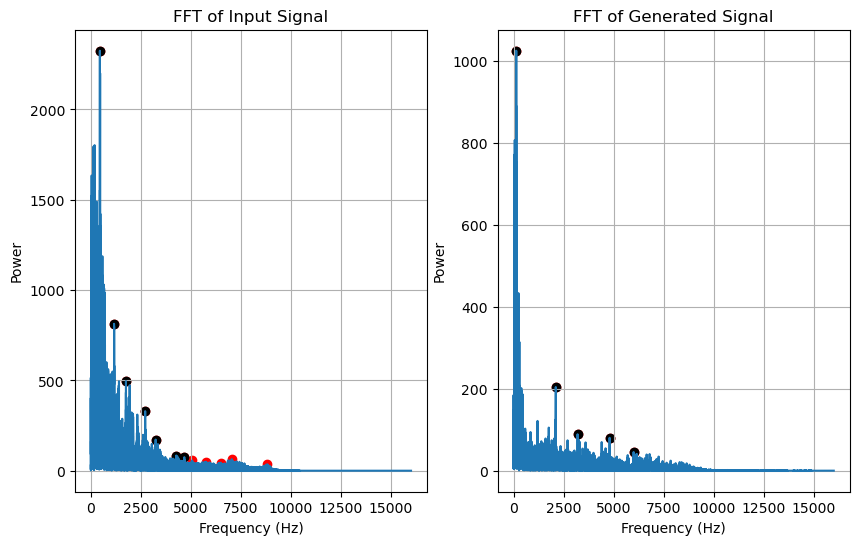

In [87]:
# INPUT SIGNAL
xf_input_signal, yf_input_signal, input_dominant_indices, input_maxima_indices = fft_and_dominant_freq(input_audio, sampling_rate, signal_strength=0.75)

# OUTPUT SIGNAL
xf_generated_signal, yf_generated_signal, generated_dominant_indices, generated_maxima_indices = fft_and_dominant_freq(generated_audio, sampling_rate, signal_strength=0.75)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

ax[0].plot(xf_input_signal, yf_input_signal)
ax[0].scatter(xf_input_signal[input_maxima_indices], yf_input_signal[input_maxima_indices], c='red', alpha=1)
ax[0].scatter(xf_input_signal[input_dominant_indices], yf_input_signal[input_dominant_indices], c='black', alpha=1)
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Power')
ax[0].set_title("FFT of Input Signal")
ax[0].grid()

ax[1].plot(xf_generated_signal, yf_generated_signal)
ax[1].scatter(xf_generated_signal[generated_maxima_indices], yf_generated_signal[generated_maxima_indices], c='red', alpha=1)
ax[1].scatter(xf_generated_signal[generated_dominant_indices], yf_generated_signal[generated_dominant_indices], c='black', alpha=1)
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Power')
ax[1].set_title("FFT of Generated Signal")
ax[1].grid()

print("Ratio of generated dominant freq: ", xf_generated_signal[generated_dominant_indices[1:]] / xf_generated_signal[generated_dominant_indices[:-1]])

print("Ratio of input dominant freq: ", xf_input_signal[input_dominant_indices[1:]] / xf_input_signal[input_dominant_indices[:-1]])

In [ ]:
# TODO: find a bad music/melody and calculate its ratio of frequencies
# TODO: apply available music metrics to both (good and bad) these samples and there should be correlation

# Page 45 to 58: Towards Reliable Partial Music Alignments Using Multiple Synchronization Strategies 
# Link - https://link.springer.com/chapter/10.1007/978-3-642-18449-9_4
# Referred paper to align music (similarity matrix)

# Music Structure Analysis Using a Probabilistic Fitness Measure and a Greedy Search Algorithm
# Link - https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5109767
# Paper that recovers sectional parts of music (I guess segments the music piece)

In [ ]:
# verification: compute stft on 1 sec window and compute rfft on same. Verify if you get similar power of frequencies

## Chords

## Similarity Matrix